Utilizing Image-Based Deep Learning to Detect Medical Diagnoses and Manage Treatable Diseases

## 1. Business Understanding

# a) Introduction 

As I delve into the exciting realm of modern healthcare, I am driven by the profound possibilities that arise from the fusion of cutting-edge technology and medical expertise. My journey revolves around the application of image-based deep learning, an innovative approach that empowers artificial intelligence to revolutionize medical diagnostics. In this endeavor, I embark on a transformative path that holds the potential to redefine how we detect and manage diseases, ultimately improving patient outcomes. The importance of timely disease diagnosis and management cannot be overstated. My primary focus centers on leveraging image-based deep learning to address this critical need. My journey begins with a meticulously curated dataset, chosen for its relevance and accuracy, encompassing a diverse array of chest X-ray images representing two fundamental categories: Pneumonia and Normal. As I immerse myself in the realm of image-based deep learning, my aim is twofold: to harness the incredible potential of AI for medical diagnosis and to build a bridge between technology and human expertise. My commitment is to empower healthcare professionals, patients, and medical institutions alike with a tool that aids in early disease detection and effective management. This fusion of technology and compassion holds the promise of better healthcare outcomes, improved patient care, and, ultimately, the preservation of lives.

# b) Problem Statement

As I embark on this journey, my goal is to harness the power of image-based deep learning to create a robust and efficient diagnostic tool. This tool will not only enhance the accuracy of disease detection but also accelerate the diagnostic process, ultimately improving patient care and outcomes.

# c) Main Objective

My primary objective is to develop and implement an image-based deep learning system capable of accurately detecting and diagnosing medical conditions, with a specific focus on treatable diseases such as pneumonia. Through the utilization of advanced AI techniques, I aim to create a reliable and efficient tool that enhances the diagnostic process, enabling timely intervention and improving patient outcomes. This project seeks to bridge the gap between technology and healthcare.

# f) Data Understanding
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Before I embarked on this transformative venture, my dataset underwent rigorous quality control. I meticulously removed scans that were of low quality or deemed unreadable to ensure the integrity of my data. The diagnostic labels for each image category were thoughtfully assessed by two expert physicians, forming the cornerstone for training my AI system. To bolster the reliability of my dataset, a third expert meticulously reviewed the evaluation set, minimizing the potential for grading errors.

# Metrics For Success  



2. Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import cv2
from PIL import Image

In [70]:


labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                # Check if img_arr is not empty before resizing
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                else:
                    print(f"Skipped image: {os.path.join(path, img)} - Empty/invalid image")
            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)} - {str(e)}")
    return np.array(data, dtype=object)


3. Reading the Data

In [21]:
norm_path = 'chest_xray/train/NORMAL/'
pneumonia_path = 'chest_xray/train/PNEUMONIA/'


In [40]:
# Define path to the data directory
data_dir = ['chest_xray/train/NORMAL/', 'chest_xray/train/PNEUMONIA/']

In [34]:
# Combine the paths into a single string representing the data directory
data_dir = os.path.join(*data_dir)

In [62]:
train = 'chest_xray/train'
val = 'chest_xray/val'
test = 'chest_xray/test'

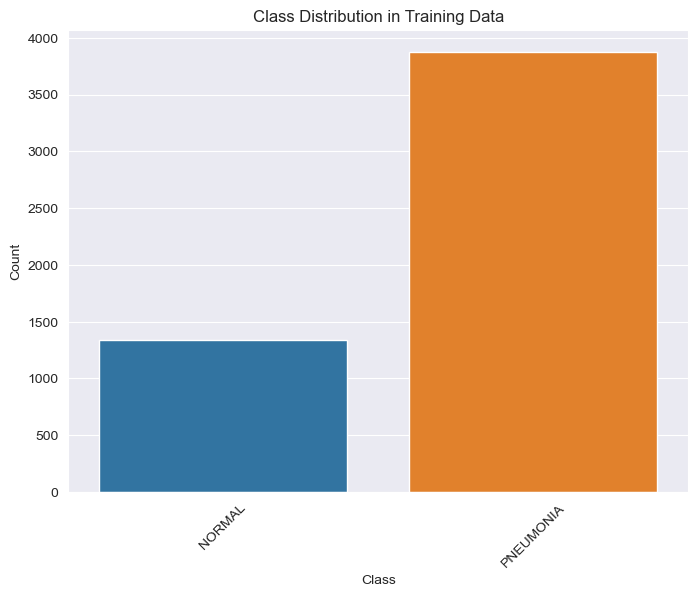

In [63]:
# Define the path to your training directory
train_dir = train

# Get a list of subdirectories in the training directory (each subdirectory represents a class)
class_dirs = os.listdir(train_dir)

# Get the class names based on the subdirectory names
class_names = [class_dir for class_dir in class_dirs if os.path.isdir(os.path.join(train_dir, class_dir))]

# Count the number of images in each class
class_counts = [len(os.listdir(os.path.join(train_dir, class_dir))) for class_dir in class_names]

# Create a countplot to visualize the class distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.barplot(x=class_names, y=class_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)  # Rotate class names on the x-axis for better visibility
plt.show()

4. Normalization and Data Augmentation

In [77]:
train = get_training_data('chest_xray/train')
val = get_training_data('chest_xray/val')
test = get_training_data('chest_xray/test')

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [74]:
# The CNN converges faster on [0..1] so normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
x_train.shape

(5216, 150, 150)

In [75]:
# resize data 
X_train = x_train.reshape(-1, img_size, img_size, 1)
Y_train = np.array(y_train)

X_val = x_val.reshape(-1, img_size, img_size, 1)
Y_val = np.array(y_val)

X_test = x_test.reshape(-1, img_size, img_size, 1)
Y_test = np.array(y_test)
Y_train.shape

(5216,)

In [76]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [78]:
if len(x_train) > 0:
    x_train = np.array(x_train) / 255
    print("x_train shape:", x_train.shape)
else:
    print("x_train is empty")

if len(x_val) > 0:
    x_val = np.array(x_val) / 255
    print("x_val shape:", x_val.shape)
else:
    print("x_val is empty")

if len(x_test) > 0:
    x_test = np.array(x_test) / 255
    print("x_test shape:", x_test.shape)
else:
    print("x_test is empty")

x_train shape: (5216, 150, 150)
x_val shape: (16, 150, 150)
x_test shape: (622, 150, 150)


5. Training my model 

In [ ]:
Normalization and data augmentation

In [80]:
model = Sequential()
#first conv layer
model.add(Conv2D(16, (3, 3), padding="same", input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#second conv layer
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))
#third conv layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
#fourth conv layer
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#fifth conv layer
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
#fc layer
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))

#output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))
#optimizer and loss function
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer =opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        1

In [81]:
#Using callback to help building better model and to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [82]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size = 32) ,
                    epochs = 30 ,
                    validation_data = datagen.flow(X_val, Y_val) ,
                    callbacks = [early_stop,learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 108s 645ms/step - loss: 0.3474 - accuracy: 0.8430 - val_loss: 3.2993 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 126s 773ms/step - loss: 0.2599 - accuracy: 0.8877 - val_loss: 4.6106 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9020
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 111s 679ms/step - loss: 0.2377 - accuracy: 0.9020 - val_loss: 2.9436 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 116s 711ms/step - loss: 0.2004 - accuracy: 0.9208 - val_loss: 3.5191 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9273
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
163/163 [=====

In [83]:
print("Loss of the model is - " , model.evaluate(X_test,Y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,Y_test)[1]*100 , "%")

20/20 [==============================] - 2s 79ms/step - loss: 0.4467 - accuracy: 0.8762
Loss of the model is -  0.44665881991386414
20/20 [==============================] - 2s 82ms/step - loss: 0.4467 - accuracy: 0.8762
Accuracy of the model is -  87.62058019638062 %


6. The Analysis of Model Training

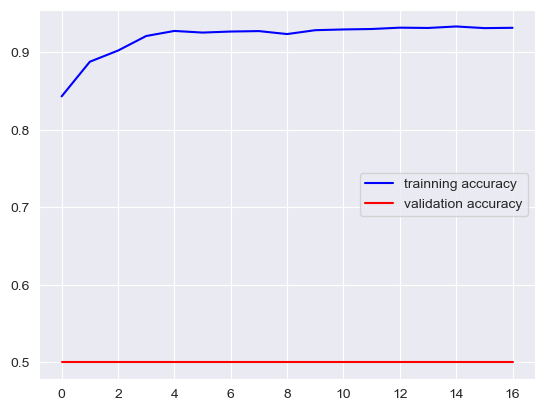

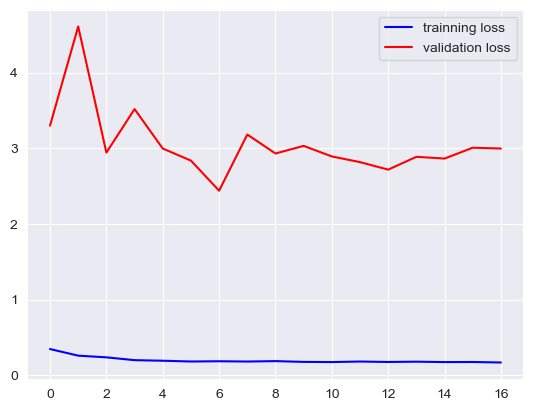

In [84]:
# visualization
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

7. Predictions

In [85]:
# You could also use "model.predict_classes(x_test)" 
#but it did not work with me bc "predict_classes" removed from my tenseflow version 2.6
predictions = (model.predict(x_test) > 0.5).astype("int32") 
predictions = predictions.reshape(1,-1)[0]
predictions[:15]
     

20/20 [==============================] - 2s 85ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [86]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.99      0.91       390
   Normal (Class 1)       0.98      0.68      0.80       232

           accuracy                           0.88       622
          macro avg       0.91      0.84      0.86       622
       weighted avg       0.89      0.88      0.87       622



In [87]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

C:\Users\HP\AppData\Local\Temp\ipykernel_9596\1245753600.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


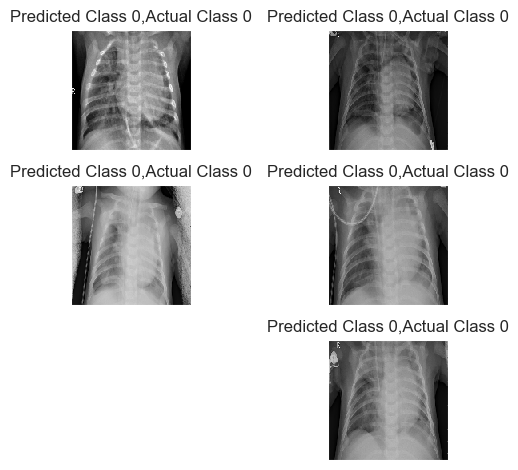

In [88]:
#Some of the Correctly Predicted Classes
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1
     

C:\Users\HP\AppData\Local\Temp\ipykernel_9596\3579382723.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


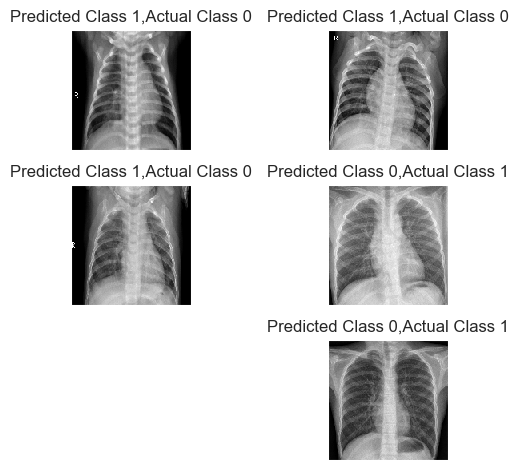

In [89]:
#Some of the Incorrectly Predicted Classes
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

8. Hyper-parameters tuning with k-folds

Random Search 

In [95]:
from kerastuner import HyperModel

NUM_CLASSES=2
INPUT_SHAPE=X_train.shape[1:]

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        #First conv layer
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                padding='same',
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        #Second conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L2',
                    values=[32, 64,128,256],
                    default=32,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=hp.Float(
                'dropout_L2',
                min_value=0.0,
                max_value=0.5,
                default=0.1,
                step=0.05,
            ))
        )
        #Third conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L3',
                    values=[32, 64,128,256],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_L3',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,
            ))
        )
        #Fourth conv layer
        model.add(
            Conv2D(
                filters=128,
                kernel_size=3,
                activation='relu'
            ))
        model.add(MaxPooling2D(pool_size=2))
        #Fifth conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L3',
                    values=[32, 64,128,256],
                    default=256,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_L5',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units_D1',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=256
                ),
                activation=hp.Choice(
                    'dense1_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_D1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )
        model.add(
            Dense(
                units=hp.Int(
                    'units_D2',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense2_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        ) 
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_D2',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [96]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband

NUM_CLASSES = 2 # chest x ray  number of classes
INPUT_SHAPE = X_train.shape[1:]  # chest x ray images input shape
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 5
EXECUTION_PER_TRIAL = 2
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='chest_x_ray'
)

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=1,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='chest_x_ray'
)
   

In [97]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_filters_L2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout_L2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
num_filters_L3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout_L3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
dropout_L5 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_D1 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_D1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'lin

In [98]:
tuner.search(X_train, Y_train, epochs=15, validation_split=0.1)

Trial 46 Complete [00h 08m 39s]
val_accuracy: 0.8955938816070557

Best val_accuracy So Far: 0.9521072804927826
Total elapsed time: 06h 51m 05s

Search: Running Trial #47

Value             |Best Value So Far |Hyperparameter
128               |128               |num_filters_L2
0.05              |0.05              |dropout_L2
64                |64                |num_filters_L3
0                 |0                 |dropout_L3
0.2               |0.2               |dropout_L5
384               |384               |units_D1
relu              |relu              |dense1_activation
0.2               |0.2               |dropout_D1
160               |160               |units_D2
sigmoid           |sigmoid           |dense2_activation
0.35              |0.35              |dropout_D2
0.0015142         |0.0015142         |learning_rate
14                |5                 |tuner/epochs
5                 |2                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2     

KeyboardInterrupt: 

In [99]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, Y_test)

Results summary
Results in hyperband\chest_x_ray
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0038 summary
Hyperparameters:
num_filters_L2: 128
dropout_L2: 0.05
num_filters_L3: 64
dropout_L3: 0.0
dropout_L5: 0.2
units_D1: 384
dense1_activation: relu
dropout_D1: 0.2
units_D2: 160
dense2_activation: sigmoid
dropout_D2: 0.35000000000000003
learning_rate: 0.0015141913494764387
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0026
Score: 0.9521072804927826

Trial 0040 summary
Hyperparameters:
num_filters_L2: 256
dropout_L2: 0.35000000000000003
num_filters_L3: 256
dropout_L3: 0.35000000000000003
dropout_L5: 0.30000000000000004
units_D1: 64
dense1_activation: relu
dropout_D1: 0.4
units_D2: 416
dense2_activation: relu
dropout_D2: 0.15000000000000002
learning_rate: 0.00017156481353511826
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0030
Score: 0.9319923222064972

Trial 0024 summary
H

K folds Cross Validation 

In [100]:
from keras.callbacks import ModelCheckpoint
# Function to create model, required for KerasClassifier
def create_model():

  model = Sequential()
  #first conv layer
  model.add(Conv2D(16, (3, 3), padding="same", input_shape = (150,150,1)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  #second conv layer
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #third conv layer
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #fourth conv layer
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  #fifth conv layer
  model.add(Conv2D(256, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #fc layer
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  #output layer
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  #optimizer and loss function
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer =opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
  return model
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Project-Deep', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [101]:
n_folds=5
epochs=20
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8802
Epoch 1: val_loss improved from inf to 1.09099, saving model to /content/drive/MyDrive\Project-Deep
INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 75s 547ms/step - loss: 0.2855 - accuracy: 0.8802 - val_loss: 1.0910 - val_accuracy: 0.7574
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9439
Epoch 2: val_loss did not improve from 1.09099
132/132 [==============================] - 55s 418ms/step - loss: 0.1413 - accuracy: 0.9439 - val_loss: 1.8459 - val_accuracy: 0.7574
Epoch 3/20
132/132 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9446
Epoch 3: val_loss did not improve from 1.09099
132/132 [==============================] - 68s 512ms/step - loss: 0.1380 - accuracy: 0.9446 - val_loss: 1.8510 - val_accuracy: 0.7574
Epoch 4/20
132/132 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9602
Epoch 4: val_loss did not improve from 1.09099
132/132 [==============================] - 84s 636ms/step - loss: 0.1048 - accuracy: 0.9602 - val_loss: 1.4566 - val_accuracy: 0.7574
Epoch 5/20
132/132 [===============

INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 98s 742ms/step - loss: 0.0905 - accuracy: 0.9666 - val_loss: 0.7640 - val_accuracy: 0.8064
Epoch 6/20
132/132 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9704
Epoch 6: val_loss improved from 0.76401 to 0.33647, saving model to /content/drive/MyDrive\Project-Deep
INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 99s 748ms/step - loss: 0.0760 - accuracy: 0.9704 - val_loss: 0.3365 - val_accuracy: 0.9043
Epoch 7/20
132/132 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9680
Epoch 7: val_loss improved from 0.33647 to 0.17516, saving model to /content/drive/MyDrive\Project-Deep
INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 99s 752ms/step - loss: 0.0784 - accuracy: 0.9680 - val_loss: 0.1752 - val_accuracy: 0.9532
Epoch 8/20
132/132 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9704
Epoch 8: val_loss did not improve from 0.17516
132/132 [==============================] - 93s 707ms/step - loss: 0.0721 - accuracy: 0.9704 - val_loss: 0.2124 - val_accuracy: 0.9404
Epoch 9/20
132/132 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9794
Epoch 9: val_loss improved from 0.17516 to 0.06558, saving model to /content/drive/MyDrive\Project-Deep
INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 89s 672ms/step - loss: 0.0563 - accuracy: 0.9794 - val_loss: 0.0656 - val_accuracy: 0.9830
Epoch 10/20
132/132 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9768
Epoch 10: val_loss did not improve from 0.06558
132/132 [==============================] - 80s 603ms/step - loss: 0.0588 - accuracy: 0.9768 - val_loss: 0.1087 - val_accuracy: 0.9617
Epoch 11/20
132/132 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9804
Epoch 11: val_loss did not improve from 0.06558
132/132 [==============================] - 78s 587ms/step - loss: 0.0524 - accuracy: 0.9804 - val_loss: 0.1716 - val_accuracy: 0.9553
Epoch 12/20
132/132 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9815
Epoch 12: val_loss did not improve from 0.06558
132/132 [==============================] - 80s 608ms/step - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.2659 - val_accuracy: 0.9298
Epoch 13/20
132/132 [========

INFO:tensorflow:Assets written to: /content/drive/MyDrive\Project-Deep\assets


132/132 [==============================] - 59s 448ms/step - loss: 0.0387 - accuracy: 0.9848 - val_loss: 0.0468 - val_accuracy: 0.9766
Epoch 15/20
132/132 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9882
Epoch 15: val_loss did not improve from 0.04676
132/132 [==============================] - 58s 437ms/step - loss: 0.0389 - accuracy: 0.9882 - val_loss: 0.0571 - val_accuracy: 0.9766
Epoch 16/20
132/132 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9834
Epoch 16: val_loss did not improve from 0.04676
132/132 [==============================] - 55s 416ms/step - loss: 0.0414 - accuracy: 0.9834 - val_loss: 0.0942 - val_accuracy: 0.9723
Epoch 17/20
132/132 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9872
Epoch 17: val_loss did not improve from 0.04676
132/132 [==============================] - 78s 589ms/step - loss: 0.0379 - accuracy: 0.9872 - val_loss: 0.1479 - val_accuracy: 0.9574
Epoch 18/20
132/132 [========

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='pink', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='pink', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()